<a href="https://colab.research.google.com/github/min207/ESAA/blob/main/ESAA_1031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**평가**
- 머신러닝: 데이터 가공/변환, 모델 학습/예측, 평가의 프로세스로 구성
  + 분류의 성능 평가 지표
    - 정확도(Accuracy)
    - 오차행렬(Confusion Matrix)
    - 정밀도(Precision)
    - 재현율(Recall)
    - F1 스코어
    - ROC AUC
----

### 01. 정확도(Accuracy)
: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
#####**정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수**

- 직관적으로 모델 예측 성능을 나타내는 평가 지표
- 이진 분류의 경우, 데이터의 구성에 따라 머신로닝 모델의 성능을 왜곡할 수도 있음

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] ==1:
                pred[i] = 0
            else :
                pred[i] = 1
        
        return pred

In [2]:
#이전에 사용한 transform_features 함수

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df
                  
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

def format_features(df):
  df['Cabin']=df['Cabin'].str[:1]
  features=['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le=LabelEncoder()
    le.fit(df[feature])
    df[feature]=le.transform(df[feature])
  return df

def transform_features(df):
  df=fillna(df)
  df=drop_features(df)
  df=format_features(df)
  return df

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


정확도 결과 약 78.77%
- 불균형한 레이블 값 분포에서 머신러닝 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님

+ MNIST 데이터 세트: 0~9까지의 숫자 이미지의 픽셀 정보, 이를 기반으로 숫자 Digit를 예측하는 데 사용

In [5]:
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어 반환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

digits=load_digits()

y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test= train_test_split(digits.data, y, random_state=11)

In [6]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정학도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- 단지 predict()의 결과를 np.zeros()로 모두 0 값으로 반환함에도 불구하고 450개의 테스트 데이터 세트에 수행한 예측 정확도가 90%
- 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안됨
---
### 02. 오차 행렬
: 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
- 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄
- TN, FP, FN, TP 형태로 오차 행렬의 4분면을 채울 수 있음
  + TN: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
  + FP는 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
  + FN은 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
  + TP는 예측값을 Positive 값 1로 예측했고 실제 값 역시 Positive 값 1

In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- ndarray 형태로 오차 행렬 출력
- 이를 통해 정확도, 정밀도, 재현율 값을 계산 가능
  + 정확도 = (TN + TP)/(TN + FP + FN + TP)

---
### 03. 정밀도와 재현율
- 정밀도 : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  + TP / (FP + TP)
  + Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표, 양성 예측도라고도 불림

- 재현율 : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  + TP / (FN + TP)
  + 민감도(Sensitivity) 또는 TPR(True Positive Rate)라고도 불림
  + 재현율은 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우에 중요 지표가 됨

- 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용
- 재현율과 정밀도 모두 높은 수치를 얻는 것이 가장 좋은 성능 평가



In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 분할.
titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test= train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 정밀도/재현율 트레이드오프
  + 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음
  + 둘은 상호 보완적 평가 지표이기 때문에 한 쪽을 높이면 다른 하나의 수치는 떨어짐

- 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()를 제공
  + predict() 메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력
  + 개별 클래스의 예측 확률을 ndarray m x n 형태로 반환

In [10]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba( ) 의 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba( ) 의 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [11]:
# 임곗값을 변경하여 정밀도와 재현율의 트레이드오프 확인
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼
# 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [13]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


- 임곗값을 0.4로 낮추면서 TP가 증가하고 FN이 감소
  + 재현율이 높아짐
  + FN이 감소하면서 정밀도는 떨어짐
  + 정확도도 남아짐

In [14]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


- 임곗값 0.45가 가장 적당하다고 결론 지을 수 있음
- precision_recall_curve() API 제공
  + 실제 클래스값 배열과 Positive 칼럼의 예측 확률 배열을 입력
  + 정밀도와 재현율 값을 임곗값별 배열로 반환

In [15]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shpae:', thresholds.shape)

# 반환된 임곗값 로우가 143건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shpae: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


- 임곗값이 증가할 수록 정밀도는 증가하고, 재현율은 감소함

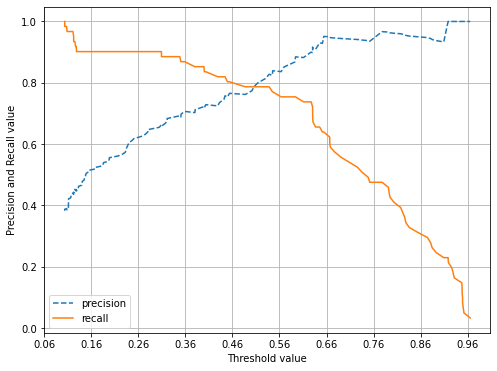

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0,1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

- 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐
---

- 정밀도와 재현율의 맹점
  + 정밀도가 100%가 되는 방법
    - 확실한 기준이 되는 경우만 양성 예측, 나머지는 모두 음성 예측
  + 재현율이 100%가 되는 방법
    - 모든 환자를 양성 예측

  + 이렇게 극단적인 수치 조작이 가능하기 때문에 정밀도 또는 재현율 중 하나만 스코어가 좋은 경우에는 성능이 좋지 않은 분류로 간주

---
### 04. F1 스코어
: 정밀도와 재현율을 결합한 지표
: 정밀도와 재현율이 한 쪽으로 치우치지 않을 때 상대적으로 높은 값을 가짐
####**F1 = 2 / (1/recall + 1/precision) = 2 * {(precision * recall) / (precision + recall)}**

In [17]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [18]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


### 05. ROC 곡선과 AUC
- 이진 분류의 에측 성능 측정에서 중요하게 사용되는 지표
- ROC 곡선: 수신자 판단 곡선으로 불림
  + FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선
  + TPR: 재현율(민감도) / TNR: 특이성
  + FPR: 1 - TNR
- ROC 곡선의 가운데 직선은 최저 값으로, 직선에 가까울수록 성능이 떨어지는 것

In [19]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


- 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR 값이 점점 커짐
- FPR이 조금씩 커질 때 TPR은 가파르게 커짐

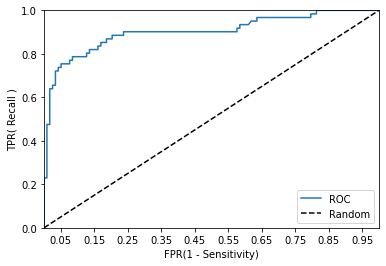

In [20]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])  

- AUC는 ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치
- 높은 AUC 수치를 위해서는 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건임
- 보통의 분류는 0.5 이상의 AUC 값을 가짐

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

#print(confusion_matrix(y_target, preds))
#print("정확도:", np.round(accuracy_score(y_target, preds), 4))
#print("정밀도:", np.round(precision_score(y_target, preds), 4))
#print("재현율:", np.round(recall_score(y_target, preds), 4))

In [23]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))